# Time series forecasting project

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA

/home/vscode/.local/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 1. Data loading

In [2]:
import seaborn as sns

# Load the 'flights' dataset
raw_data_df = sns.load_dataset("flights")

### 1.2 Inspect Data

In [3]:
raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


### 2. Data Preprocessing

In [4]:
# Make a copy of the raw data to work with
timeseries_df = raw_data_df.copy()

# Convert the month to a datetime object (only month is needed)
timeseries_df['month'] = pd.to_datetime(raw_data_df['month'], format='%b').dt.month

# Combine year and month into a 'date' column with the 1st of each month as the date
timeseries_df['date'] = pd.to_datetime(timeseries_df[['year', 'month']].assign(day=1))

# Set the 'date' column as the index
timeseries_df = timeseries_df.set_index('date')

# Drop 'year' and 'month' columns as they are no longer needed
timeseries_df.drop(['year', 'month'], axis=1, inplace=True)

# Rename 'passengers' to 'dependent_var'
timeseries_df.rename(columns={'passengers': 'dependent_var'}, inplace=True)

# Verify the changes
timeseries_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   dependent_var  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


### 3. Exploratory Data Analysis (EDA)

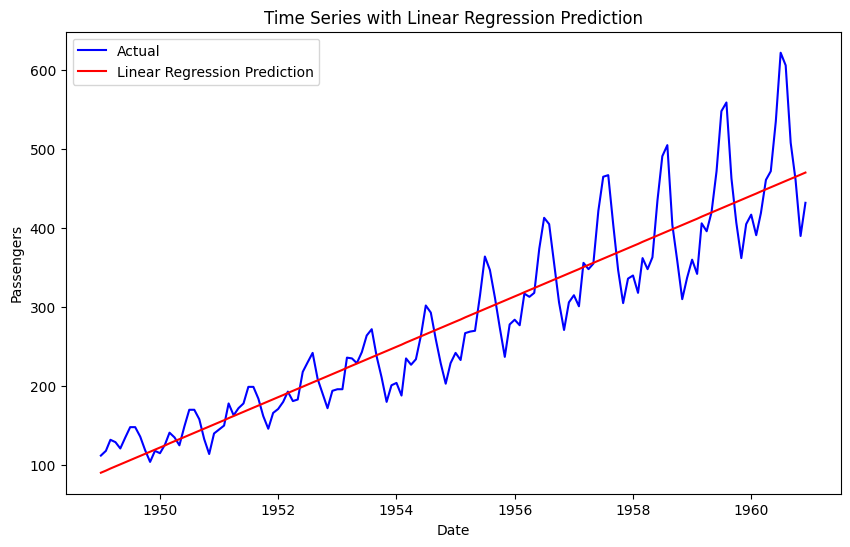

In [5]:
from sklearn.linear_model import LinearRegression

# Create a numeric range for the index as 'X'
X = np.arange(len(timeseries_df)).reshape(-1, 1)  # Reshape for the model

# Dependent variable 'y'
y = timeseries_df['dependent_var']

# Fit a Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict using the linear model
y_pred = model.predict(X)

# Plot actual vs predicted
plt.figure(figsize=(10,6))
plt.plot(timeseries_df.index, y, label='Actual', color='blue')
plt.plot(timeseries_df.index, y_pred, label='Linear Regression Prediction', color='red')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.title('Time Series with Linear Regression Prediction')
plt.legend()
plt.show()

### 2.2 Missing and/or Extreme Values

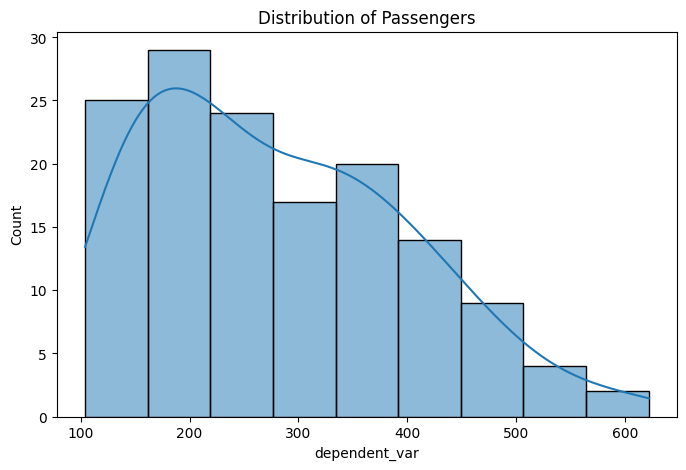

,dependent_var
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [6]:
# Plot histogram of the dependent variable
plt.figure(figsize=(8,5))
sns.histplot(timeseries_df['dependent_var'], kde=True)
plt.title('Distribution of Passengers')
plt.show()

# Check for summary statistics
timeseries_df.describe()

### 2.3 Time Series Analysis

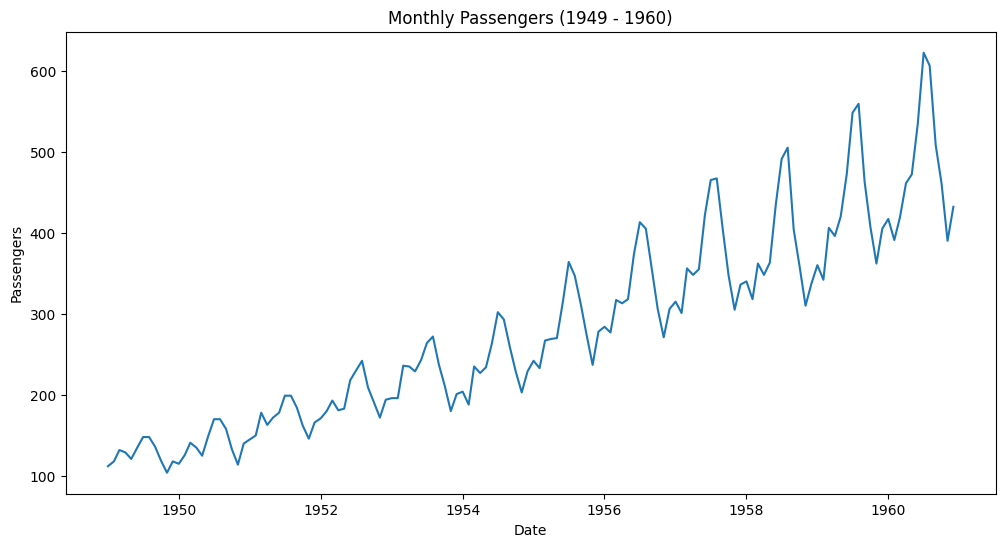

In [7]:
# Plot the time series data
plt.figure(figsize=(12,6))
plt.plot(timeseries_df.index, timeseries_df['dependent_var'])
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.title('Monthly Passengers (1949 - 1960)')
plt.show()

### 2.3.2 Missing Timepoints

In [8]:
# Check if the time series has missing months
timeseries_df_resampled = timeseries_df.resample('M').mean()  # Resample by month

# Check for missing values
print(timeseries_df_resampled.isnull().sum())

dependent_var    0
dtype: int64


### 2.3.3 Stationarity

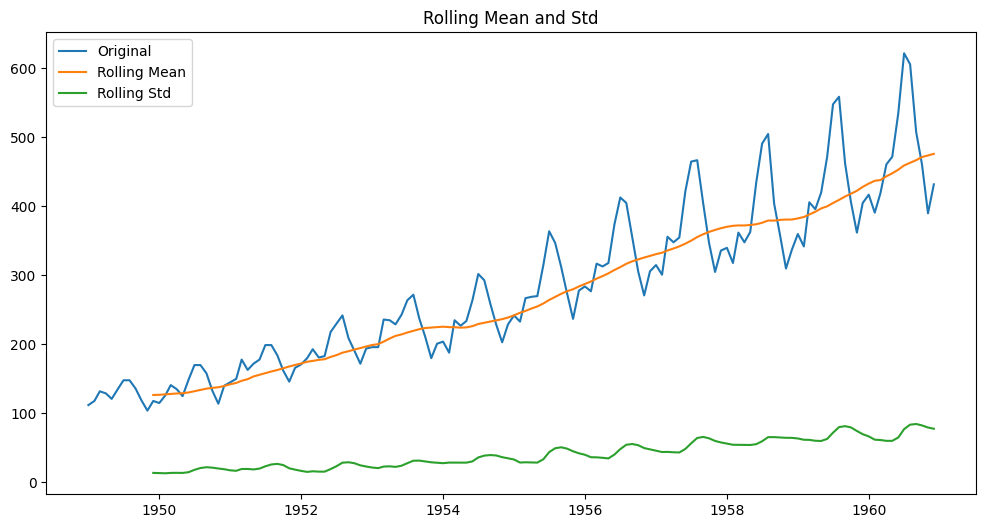

In [9]:
# Plot rolling mean and standard deviation to check stationarity
rolling_mean = timeseries_df['dependent_var'].rolling(window=12).mean()
rolling_std = timeseries_df['dependent_var'].rolling(window=12).std()

plt.figure(figsize=(12,6))
plt.plot(timeseries_df['dependent_var'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Std')
plt.show()

### 2.3.4 Seasonality

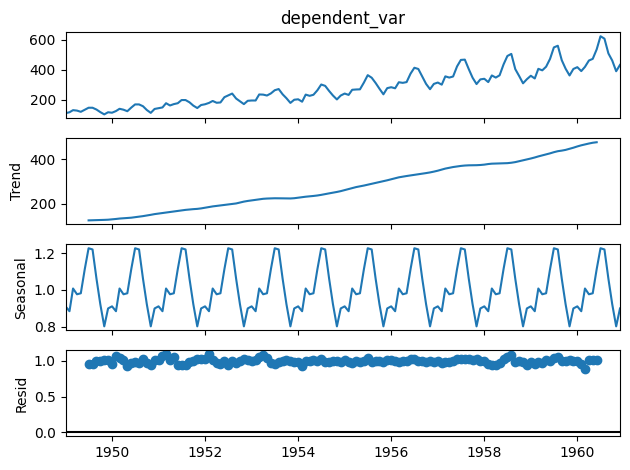

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(timeseries_df['dependent_var'], model='multiplicative', period=12)
decomposition.plot()
plt.show()

### 4. Model Training: ARIMA

In [11]:
timeseries_df['dependent_var']

date
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: dependent_var, Length: 144, dtype: int64

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1020.048, Time=0.90 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.17 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=1019.935, Time=0.58 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=1019.290, Time=0.22 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=1019.546, Time=0.63 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1024.160, Time=0.09 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1017.847, Time=0.39 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=1017.914, Time=0.45 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1018.359, Time=0.40 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=1018.248, Time=0.88 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.08 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=1022.393, Time=0.06 sec
 ARIMA(3,1,1)(0,1,0

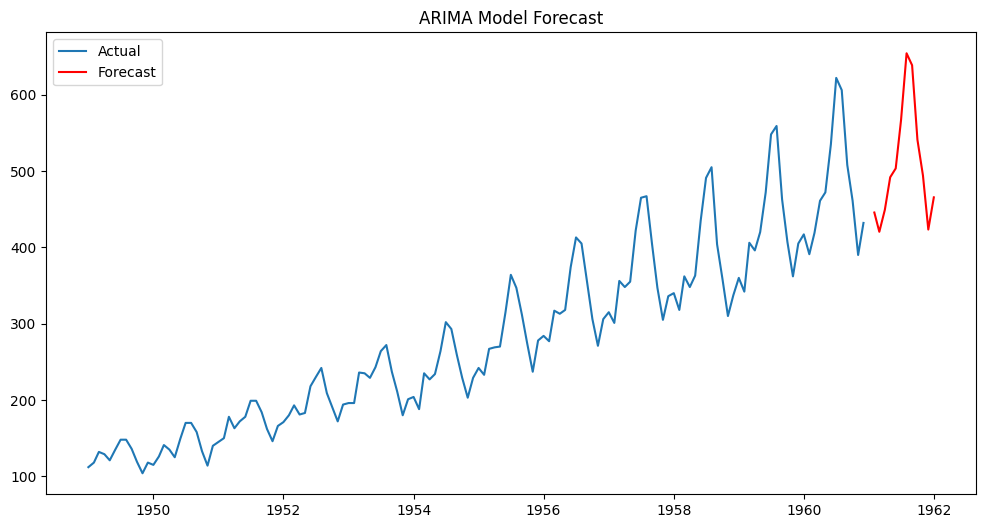

In [12]:
from pmdarima import auto_arima

# Fit the ARIMA model
model_arima = auto_arima(timeseries_df['dependent_var'], seasonal=True, m=12, trace=True, suppress_warnings=True)

# Print the model summary
print(model_arima.summary())

# Forecast the next 12 months (1 year)
forecast = model_arima.predict(n_periods=12)

# Plot the forecast
plt.figure(figsize=(12,6))
plt.plot(timeseries_df.index, timeseries_df['dependent_var'], label='Actual')
plt.plot(pd.date_range(timeseries_df.index[-1], periods=13, freq='M')[1:], forecast, label='Forecast', color='red')
plt.legend(loc='best')
plt.title('ARIMA Model Forecast')
plt.show()

### 5. Model Evaluation

In [13]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# Create TimeSeriesSplit cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Evaluate the model using TimeSeriesSplit
for train_index, test_index in tscv.split(timeseries_df):
    train, test = timeseries_df.iloc[train_index], timeseries_df.iloc[test_index]
    
    # Fit the ARIMA model on training data
    model_arima.fit(train['dependent_var'])
    
    # Predict on the test set
    predictions = model_arima.predict(n_periods=len(test))
    
    # Calculate the RMSE (Root Mean Squared Error)
    rmse = sqrt(mean_squared_error(test['dependent_var'], predictions))
    print(f'RMSE: {rmse}')

RMSE: 12.925237220419316
RMSE: 16.648961640381074
RMSE: 36.92613747596708
RMSE: 17.434148489260583
RMSE: 75.43615855077253
